In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

import pytorch_lightning as pl

In [3]:
pl.seed_everything(42);

Seed set to 42


### Dataloading

---

In [12]:
from helpers.dataset import InpaintingDataset
from helpers.data_utils import post_process_image
from omegaconf import OmegaConf

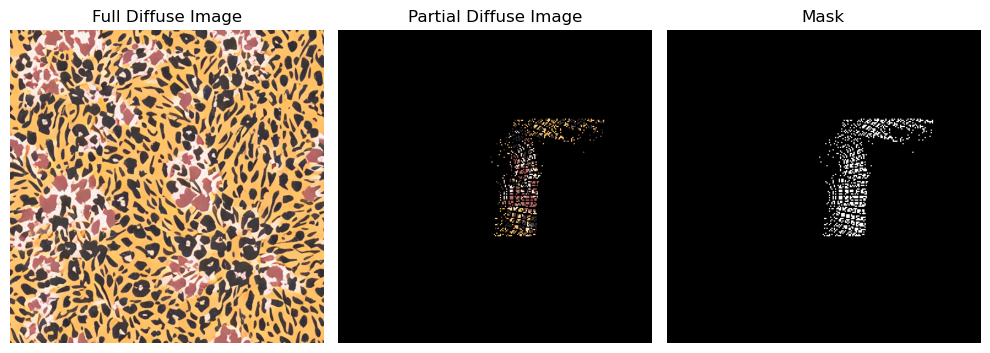

In [13]:
cfg = OmegaConf.load("../configs/train.yaml")
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]
diffuse_img = post_process_image(diffuse_img)
partial_img = post_process_image(partial_img)
mask = post_process_image(sample["mask"])


fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(diffuse_img)
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(partial_img)
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

ax[2].imshow(mask)
ax[2].set_title("Mask")
ax[2].axis("off")

plt.tight_layout()

### Vae encoding and decoding

---

In [ ]:
import os
import torch
from diffusers import AutoencoderKL

from omegaconf import OmegaConf
from helpers.dataset import InpaintingDataset

from matplotlib import pyplot as plt
from helpers import data_utils

In [ ]:
path_to_config = "/home/cizinsky/garment-texture-completion/configs/train.yaml"
with open(path_to_config, "r") as f:
    cfg = OmegaConf.load(f)

vae_path = os.path.join(cfg.model.vae_path, "refine_vae")
vae_diffuse = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae_checkpoint_diffuse",
    revision="fp32",
    local_files_only=True,
    torch_dtype=torch.float32,
).to("cuda").eval()

dataset = InpaintingDataset(cfg)


sample = dataset[0]
diffuse_img, partial_img = sample["full_diffuse_img"][None], sample["partial_diffuse_img"][None]
diffuse_img.shape, partial_img.shape

In [ ]:
tmp_diffuse_img, tmp_partial_img = data_utils.channels_last(diffuse_img), data_utils.channels_last(partial_img)
tmp_diffuse_img, tmp_partial_img = data_utils.denormalise_image(tmp_diffuse_img), data_utils.denormalise_image(tmp_partial_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(tmp_diffuse_img.squeeze(0))
ax[0].set_title("Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(tmp_partial_img.squeeze(0))
ax[1].set_title("Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

In [12]:
def encode_decode_image(image, vae):
    # Encode
    with torch.no_grad():
        latents = vae.encode(image.cuda()).latent_dist.sample()
        latents = latents * vae.config.scaling_factor  # scale to match diffusion training

    # Decode
    with torch.no_grad():
        decoded = vae.decode(latents / vae.config.scaling_factor).sample

    return decoded

def post_process_image(image):
    decoded_image = data_utils.channels_last(data_utils.denormalise_image(image.cpu().numpy()))
    return decoded_image

In [ ]:
tensor_full, tensor_partial = torch.from_numpy(diffuse_img), torch.from_numpy(partial_img)
decoded_full, decoded_partial = encode_decode_image(tensor_full, vae_diffuse), encode_decode_image(tensor_partial, vae_diffuse)
decoded_full, decoded_partial = post_process_image(decoded_full), post_process_image(decoded_partial)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(decoded_full[0])
ax[0].set_title("Decoded Full Diffuse Image")
ax[0].axis("off")

ax[1].imshow(decoded_partial[0])
ax[1].set_title("Decoded Partial Diffuse Image")
ax[1].axis("off")

plt.tight_layout()

### Inference

---

In [42]:
from helpers.dataset import InpaintingDataset
from helpers.pl_module import GarmentInpainterModule
from helpers.data_utils import post_process_image

from omegaconf import OmegaConf
from matplotlib import pyplot as plt

import torch

In [6]:
cfg = OmegaConf.load("../configs/train.yaml")

In [40]:
model = GarmentInpainterModule(cfg, None, None).to("cuda").to(torch.float16).eval()
model.setup()

In [44]:
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

In [ ]:
image = partial_img
post_img = post_process_image(image)

plt.imshow(post_img)
plt.axis("off")
plt.show()

In [ ]:
x_in = torch.from_numpy(image).unsqueeze(0)
strengths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
post_inpainted_imgs = []
for strength in strengths:
    inpainted_img = model.inference(x_in.cuda(), strength=strength, num_inference_steps=100)
    post_inpainted_imgs.append(post_process_image(inpainted_img.to(torch.float32)))

In [ ]:
fig, ax = plt.subplots(1, len(strengths), figsize=(20, 5))
for i, post_inpainted_img in enumerate(post_inpainted_imgs):
    ax[i].imshow(post_inpainted_img[0])
    ax[i].axis("off")
    ax[i].set_title(f"Strength: {strengths[i]}")
plt.tight_layout()
plt.show()

### Metrics Computation

---

In [ ]:
from helpers.dataset import InpaintingDataset
from helpers.pl_module import GarmentInpainterModule
from helpers.data_utils import post_process_image, denormalise_image
from helpers.metrics import compute_ssim, compute_psnr, compute_lpips, compute_all_metrics

from omegaconf import OmegaConf
import torch

In [5]:
cfg = OmegaConf.load("../configs/train.yaml")

In [6]:
dataset = InpaintingDataset(cfg)
i = random.randint(0, len(dataset) - 1)
sample = dataset[i]

diffuse_img, partial_img = sample["full_diffuse_img"], sample["partial_diffuse_img"]

In [ ]:
image = diffuse_img
post_img = post_process_image(image)

plt.imshow(post_img)
plt.axis("off")
plt.show()

In [ ]:
# B x C x H x W
diffuse_img.shape, diffuse_img.min(), diffuse_img.max()

In [ ]:
diffuse_img_denormalised = torch.from_numpy(denormalise_image(diffuse_img)).unsqueeze(0)
diffuse_img_denormalised.shape, diffuse_img_denormalised.min(), diffuse_img_denormalised.max()

In [ ]:
lpips = compute_lpips(diffuse_img_denormalised, diffuse_img_denormalised)
ssim = compute_ssim(diffuse_img_denormalised, diffuse_img_denormalised)
psnr = compute_psnr(diffuse_img_denormalised, diffuse_img_denormalised)

print(f"LPIPS: {lpips}, SSIM: {ssim}, PSNR: {psnr}")

In [ ]:
tiny_noise = torch.randn(diffuse_img_denormalised.shape)
lpips = compute_lpips(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)
ssim = compute_ssim(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)
psnr = compute_psnr(diffuse_img_denormalised + tiny_noise, diffuse_img_denormalised)

print(f"LPIPS: {lpips}, SSIM: {ssim}, PSNR: {psnr}")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

post_img = post_process_image(diffuse_img)
ax[0].imshow(post_img)
ax[0].axis("off")
ax[0].set_title("Original Image")

tiny_noise_arr = tiny_noise.cpu().numpy()[0]
post_img_with_noise = post_process_image(diffuse_img + tiny_noise_arr)
ax[1].imshow(post_img_with_noise)
ax[1].axis("off")
ax[1].set_title("Image with Tiny Noise")

plt.tight_layout()
plt.show()

In [45]:
model = GarmentInpainterModule(cfg, None, None).to("cuda").to(torch.float16).eval()
model.setup()

In [ ]:
x_in = torch.from_numpy(partial_img).unsqueeze(0)
denorm_full_img = torch.from_numpy(denormalise_image(diffuse_img)).unsqueeze(0)
strengths = [0.1, 0.2, 0.3, 0.4, 0.5]
post_inpainted_imgs = []
metrics = []
for strength in strengths:
    inpainted_img = model.inference(x_in.cuda(), strength=strength, num_inference_steps=100)
    post_inpainted_imgs.append(post_process_image(inpainted_img.to(torch.float32)))

    denorm_inpainted_img = torch.from_numpy(denormalise_image(inpainted_img.to(torch.float32).cpu().numpy()))
    metrics.append(compute_all_metrics(denorm_inpainted_img, denorm_full_img))

fig, ax = plt.subplots(1, len(strengths), figsize=(20, 5))
for i, post_inpainted_img in enumerate(post_inpainted_imgs):
    metrics_dict = metrics[i]
    ax[i].imshow(post_inpainted_img[0])
    ax[i].axis("off")
    ax[i].set_title(f"Strength: {strengths[i]}")
    ax[i].text(0.5, -0.1, f"SSIM: {metrics_dict['ssim']:.4f}\nPSNR: {metrics_dict['psnr']:.4f}\nLPIPS: {metrics_dict['lpips']:.4f}",
               ha='center', va='top', transform=ax[i].transAxes, fontsize=12)

plt.tight_layout()
plt.show()


### Validation

---

In [ ]:
from helpers.dataset import InpaintingDataset, get_dataloaders
from helpers.pl_module import GarmentInpainterModule
from helpers.data_utils import post_process_image, denormalise_image
from helpers.metrics import compute_ssim, compute_psnr, compute_lpips, compute_all_metrics

from omegaconf import OmegaConf
from tqdm import tqdm
import torch
import numpy as np

import ipywidgets as widgets
from IPython.display import display

In [4]:
cfg = OmegaConf.load("../configs/train.yaml")

model = GarmentInpainterModule(cfg, None).to("cuda").to(torch.float16).eval()
model.setup()

dataset = InpaintingDataset(cfg)

In [5]:
np.random.seed(42)
_, val_loader = get_dataloaders(cfg)

In [ ]:
images = []
for batch in tqdm(val_loader, total=len(val_loader)):
    batch_images = post_process_image(batch["full_diffuse_img"])
    batch_names = [path.split("/")[-1] for path in batch["path"]]
    combined = []
    for image, name in zip(batch_images, batch_names):
        combined.append((image, name))
    
    images.extend(combined)

In [ ]:
def show_image_matplotlib(index):
    img = images[index][0]
    plt.imshow(img)
    plt.axis('off')
    
    name = images[index][1]
    plt.title(f"Image {name}")
    plt.show()

widgets.interact(show_image_matplotlib, index=widgets.IntSlider(0, 0, len(images) - 1));

### Testing different inference pipelines

---

In [4]:
CKPT_ROOT = '/scratch/izar/cizinsky/garment-completion/checkpoints'

from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider

import torch

from diffusers import StableDiffusionInstructPix2PixPipeline, AutoencoderKL
from diffusers import DDIMScheduler

from transformers import CLIPTextModel, CLIPTokenizer

from helpers.pl_module import GarmentInpainterModule
from helpers.dataset import get_dataloaders
from helpers.data_utils import denormalise_image_torch
from helpers.data_utils import torch_image_to_pil, denormalise_image_torch

In [5]:
run_name = "lilac-hill-102"
checkpoint_path = f"{CKPT_ROOT}/{run_name}/last.ckpt"
print("CKPT exists: ", os.path.exists(checkpoint_path))

checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
cfg = checkpoint["hyper_parameters"]
trn_dataloader, val_dataloader = get_dataloaders(cfg)

model = GarmentInpainterModule(cfg, trn_dataloader)
model.setup()
model.load_state_dict(checkpoint["state_dict"])
model.eval().cuda()
print("✅ Model loaded!")

CKPT exists:  True


/home/cizinsky/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Model loaded!


In [6]:
# Pretrained modules
pretrained_model = "stable-diffusion-v1-5/stable-diffusion-v1-5"

vae_dir = "/home/cizinsky/garment-texture-completion/data_generation/dresscode/material_gen"
vae_path = os.path.join(vae_dir, "refine_vae")
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae_checkpoint_diffuse",
    revision="fp32",
    local_files_only=True,
    torch_dtype=torch.float32,
).to("cuda").eval()

# Fine-tuned modules
unet = model.model.unet

# Scheduler
scheduler = DDIMScheduler.from_pretrained(
    pretrained_model,
    subfolder="scheduler",
    revision=None,
    torch_dtype=torch.float32,
)


In [10]:
invpipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
        pretrained_model,
        unet=unet,
        vae=vae,
        scheduler=scheduler,
        revision=None,
        safety_checker=None,
        torch_dtype=torch.float32,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
batch = next(iter(val_dataloader))

/home/cizinsky/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
prompts = ["fill the missing parts of a fabric texture matching the existing colors and style"]*20
zero_one_img_tensors = denormalise_image_torch(batch["partial_diffuse_img"])
preds = invpipe(
    prompts,
    image=zero_one_img_tensors,
    num_inference_steps=50,
    image_guidance_scale=1.5,
    guidance_scale=7,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
cond_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["partial_diffuse_img"])]
target_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["full_diffuse_img"])]

In [13]:
def plot_images(index):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(cond_images[index])
    axs[0].set_title("Condition")
    axs[0].axis("off")
    axs[1].imshow(preds[index])
    axs[1].set_title("Predicted")
    axs[1].axis("off")
    axs[2].imshow(target_images[index])
    axs[2].set_title("Target")
    axs[2].axis("off")
    plt.show()

interact(plot_images, index=IntSlider(min=0, max=len(preds)-1, step=1));

TypeError: object of type 'Image' has no len()